Tutorial based on scanpy-tutorials.readthedocs.io

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

# scRNAseq data analysis

## Loading libs, data, setting up options

In [2]:
!pip install scanpy
!pip3 install leidenalg
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=368370026b726b89570a31d85cd4fe706786a84f701c35f5929eafa68c89fcc1
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=480ab270695a7fff15a8f8ca0091a1ec67fd4493a90cc747dbdd367971265d5f
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd99

Download data

https://www.frontiersin.org/articles/10.3389/fcell.2020.00841/full

In [30]:
!cd data/ftp.ncbi.nlm.nih.gov; gunzip matrix.mtx.gz
!cd data/ftp.ncbi.nlm.nih.gov; gunzip barcodes.tsv.gz
!cd data/ftp.ncbi.nlm.nih.gov; gunzip features.tsv.gz

In [3]:
!mkdir data
#!wget -r  ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4407nnn/GSM4407907/suppl/
!cd data; wget -r --cut-dirs=5 ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4407nnn/GSM4407907/
!cd data/ftp.ncbi.nlm.nih.gov; gunzip GSM4407907_matrix.mtx.gz
!cd data/ftp.ncbi.nlm.nih.gov; gunzip GSM4407907_barcodes.tsv.gz
!cd data/ftp.ncbi.nlm.nih.gov; gunzip GSM4407907_genes.tsv.gz
!mkdir write

--2024-03-20 22:26:16--  ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4407nnn/GSM4407907/
           => ‘ftp.ncbi.nlm.nih.gov/.listing’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.11, 2607:f220:41e:250::10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/samples/GSM4407nnn/GSM4407907 ... done.
==> PASV ... done.    ==> LIST ... done.

ftp.ncbi.nlm.nih.go     [ <=>                ]      70  --.-KB/s    in 0.003s  

2024-03-20 22:26:16 (20.6 KB/s) - ‘ftp.ncbi.nlm.nih.gov/.listing’ saved [70]

Removed ‘ftp.ncbi.nlm.nih.gov/.listing’.
--2024-03-20 22:26:16--  ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4407nnn/GSM4407907/suppl/
           => ‘ftp.ncbi.nlm.nih.gov/.listing’
==> CWD (1) /geo/samples/GSM4407nnn/GSM4407907/suppl ... done.
==> PASV ... done.    ==> LIST ... done.

ftp.ncbi.nlm.nih.go

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.8 anndata==0.10.6 umap==0.5.5 numpy==1.25.2 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [5]:
results_file = "write/mouse.h5ad"  # the file that will store the analysis results

Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: .h5ad.

In [6]:
adata = sc.read_10x_mtx(
    "data/ftp.ncbi.nlm.nih.gov/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... writing an h5ad cache file to speedup reading next time


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


In [8]:
adata

AnnData object with n_obs × n_vars = 6260 × 48816
    var: 'gene_ids'

## Preprocessing steps




https://compscbio.github.io/docs/html/day/06_scRNAseq_analysis.html

normalizing counts per cell
    finished (0:00:00)


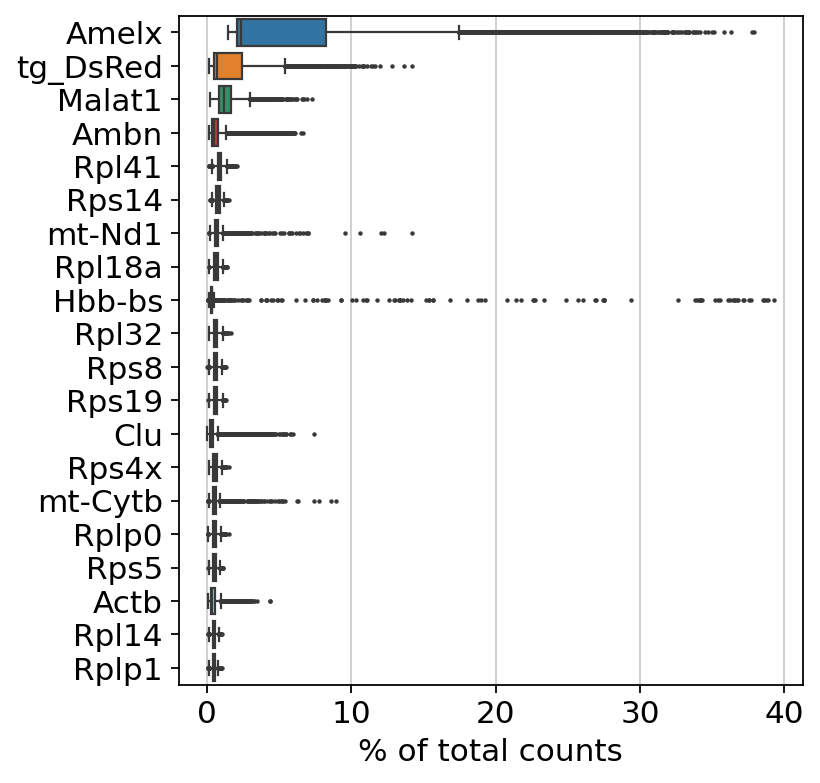

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 27757 genes that are detected in less than 3 cells


Filter mitochondrial genes

In [11]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [12]:
print(sum(adata.var['mt']))

0


ribosomal genes

In [13]:
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
print(sum(adata.var['ribo']))

297


In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

In [15]:
adata.var

gene_ids  n_cells     mt  n_cells_by_counts  \
Xkr4         ENSMUSG00000051951.5       11  False                 11   
Gm37180      ENSMUSG00000103377.1       24  False                 24   
Gm37363      ENSMUSG00000104017.1       24  False                 24   
Gm37686      ENSMUSG00000103025.1       11  False                 11   
Gm37329      ENSMUSG00000103201.1        7  False                  7   
...                           ...      ...    ...                ...   
mt-Tp        ENSMUSG00000064372.1       71  False                 71   
tg_MCherry             tg_MCherry        7  False                  7   
tg_tdTom                 tg_tdTom      651  False                651   
tg_DsRed                 tg_DsRed     6260  False               6260   
tg_beta-lac           tg_beta-lac       20  False                 20   

             mean_counts  pct_dropout_by_counts  total_counts   ribo  
Xkr4            0.001757              99.824281          11.0  False  
Gm37180         0.003834              99.616613          24.0  False  
Gm37363         0.003834              99.616613          24.0  False  
Gm37686         0.001757              99.824281          11.0  False  
Gm37329         0.001118              99.888179           7.0  False  
...                  ...                    ...           ...    ...  
mt-Tp           0.011502              98.865815          72.0  False  
tg_MCherry      0.001118              99.888179           7.0  False  
tg_tdTom        0.130351              89.600639         816.0  False  
tg_DsRed      173.570602               0.000000     1086552.0  False  
tg_beta-lac     0.003514              99.680511          22.0  False  

[21059 rows x 8 columns]

QC metrics

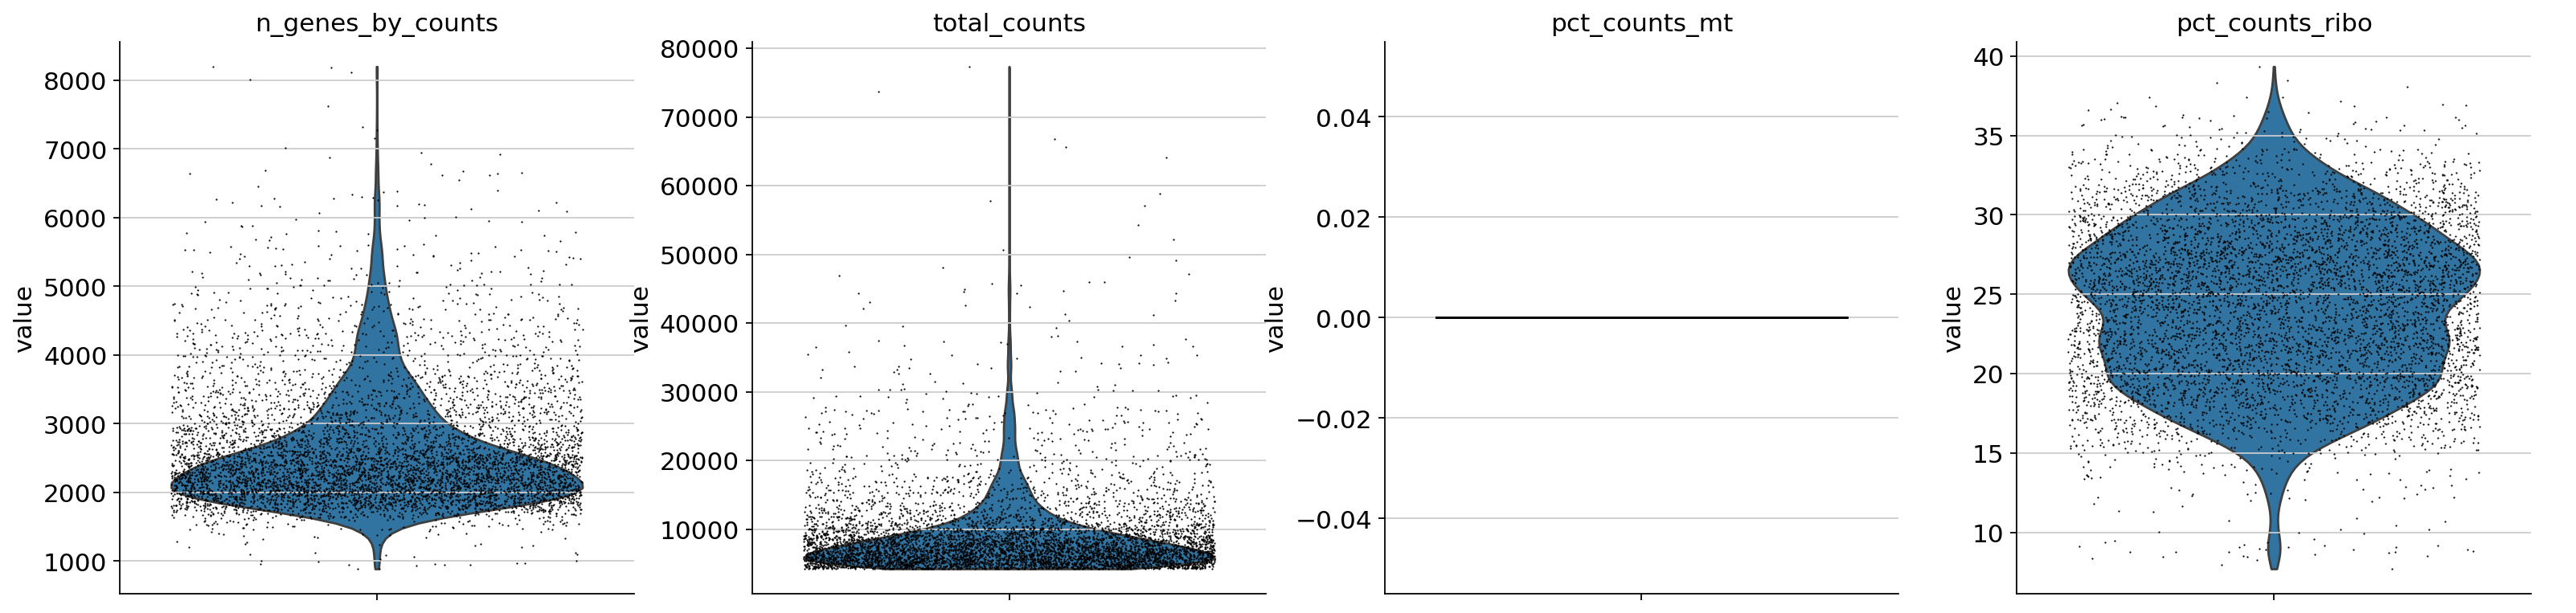

In [16]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt","pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

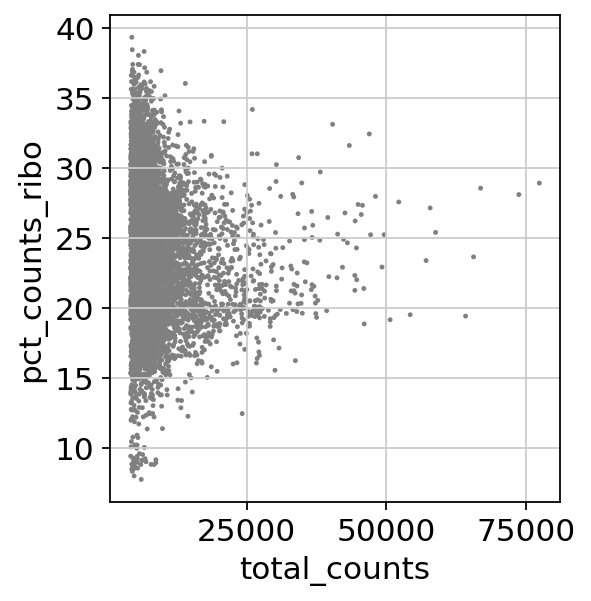

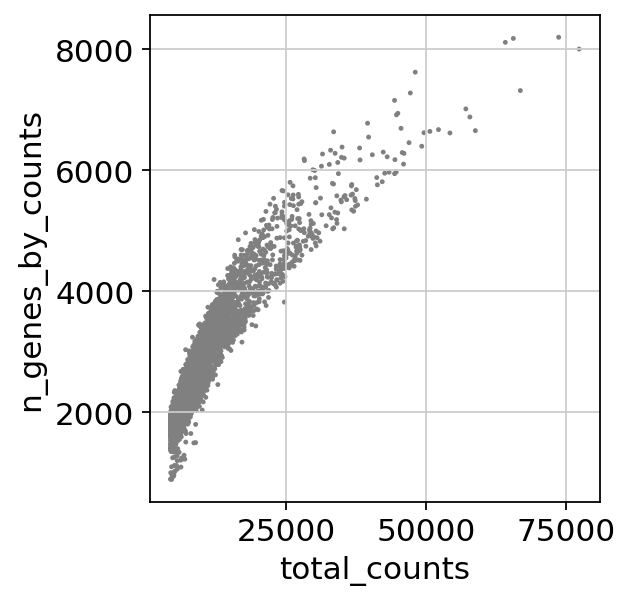

In [17]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_ribo")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [18]:
# Filtering by slicing
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata = adata[adata.obs['pct_counts_ribo'] < 50, :]

In [19]:
adata

View of AnnData object with n_obs × n_vars = 3611 × 21059
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

Normalize data

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [21]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


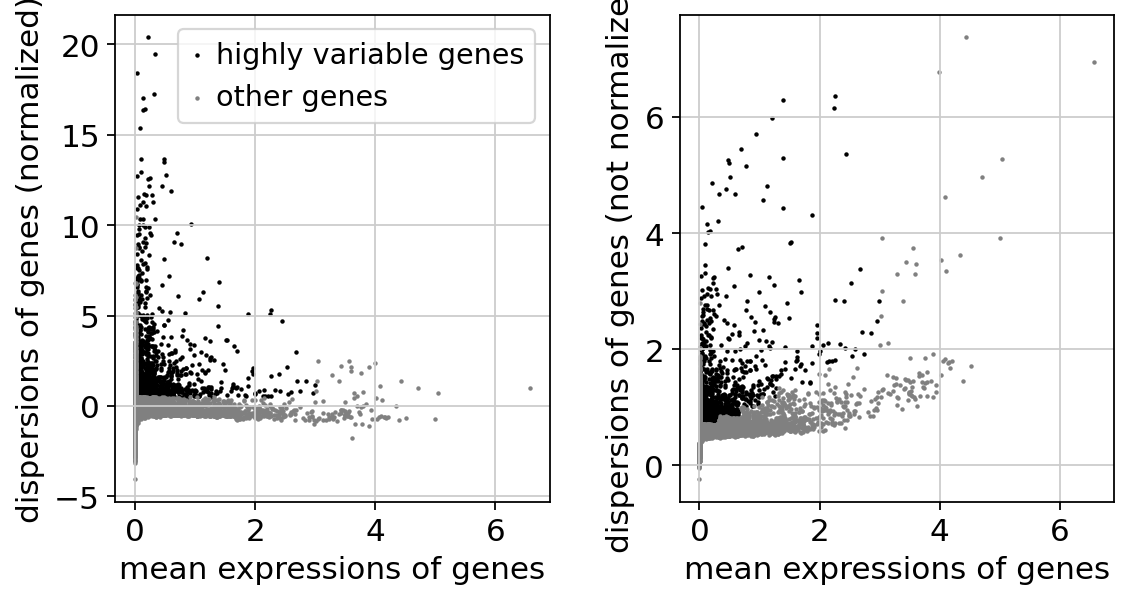

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
adata.raw = adata

Keep variable

In [25]:
adata = adata[:, adata.var.highly_variable]

In [26]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt","pct_counts_ribo"])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:12)


In [27]:
sc.pp.scale(adata, max_value=10)

## PCA

In [28]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


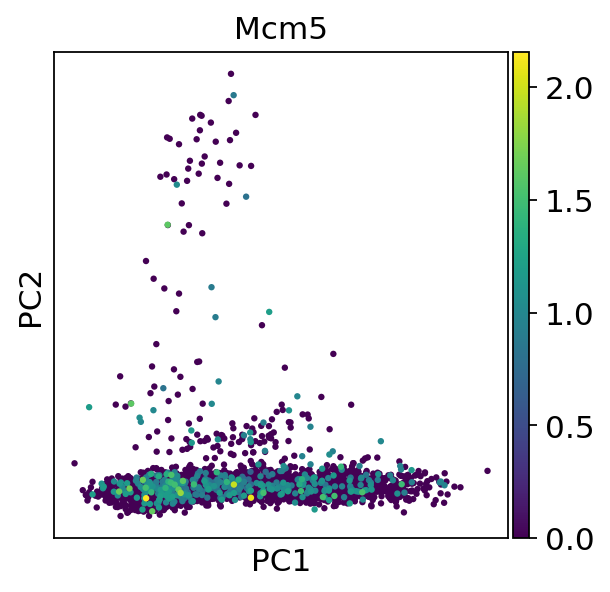

In [29]:
sc.pl.pca(adata, color="Mcm5")

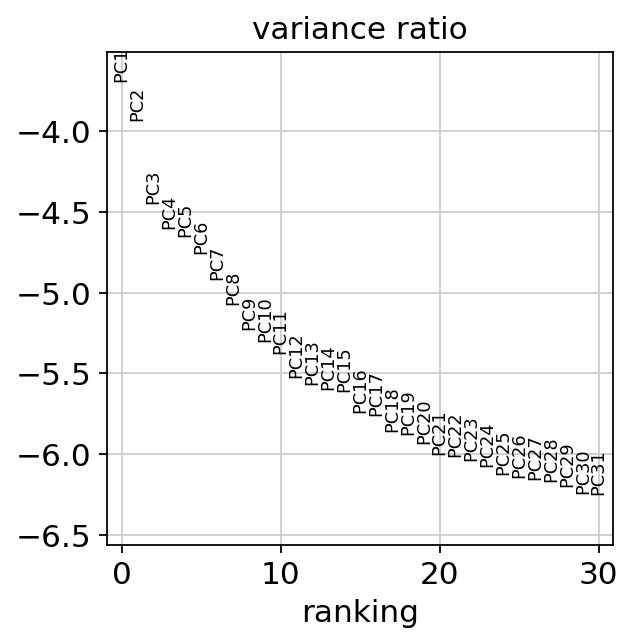

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
adata.write(results_file)

In [32]:
adata

AnnData object with n_obs × n_vars = 3611 × 1545
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Neighbourhood graph

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


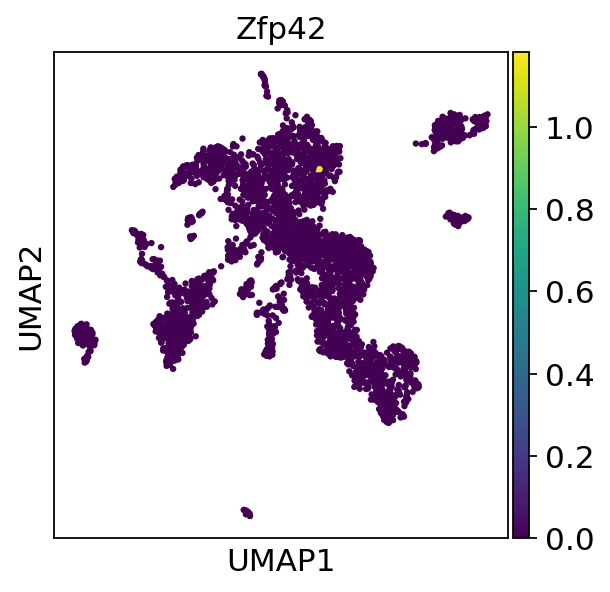

In [35]:
sc.pl.umap(adata, color=["Zfp42"])

## Clustering

In [36]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


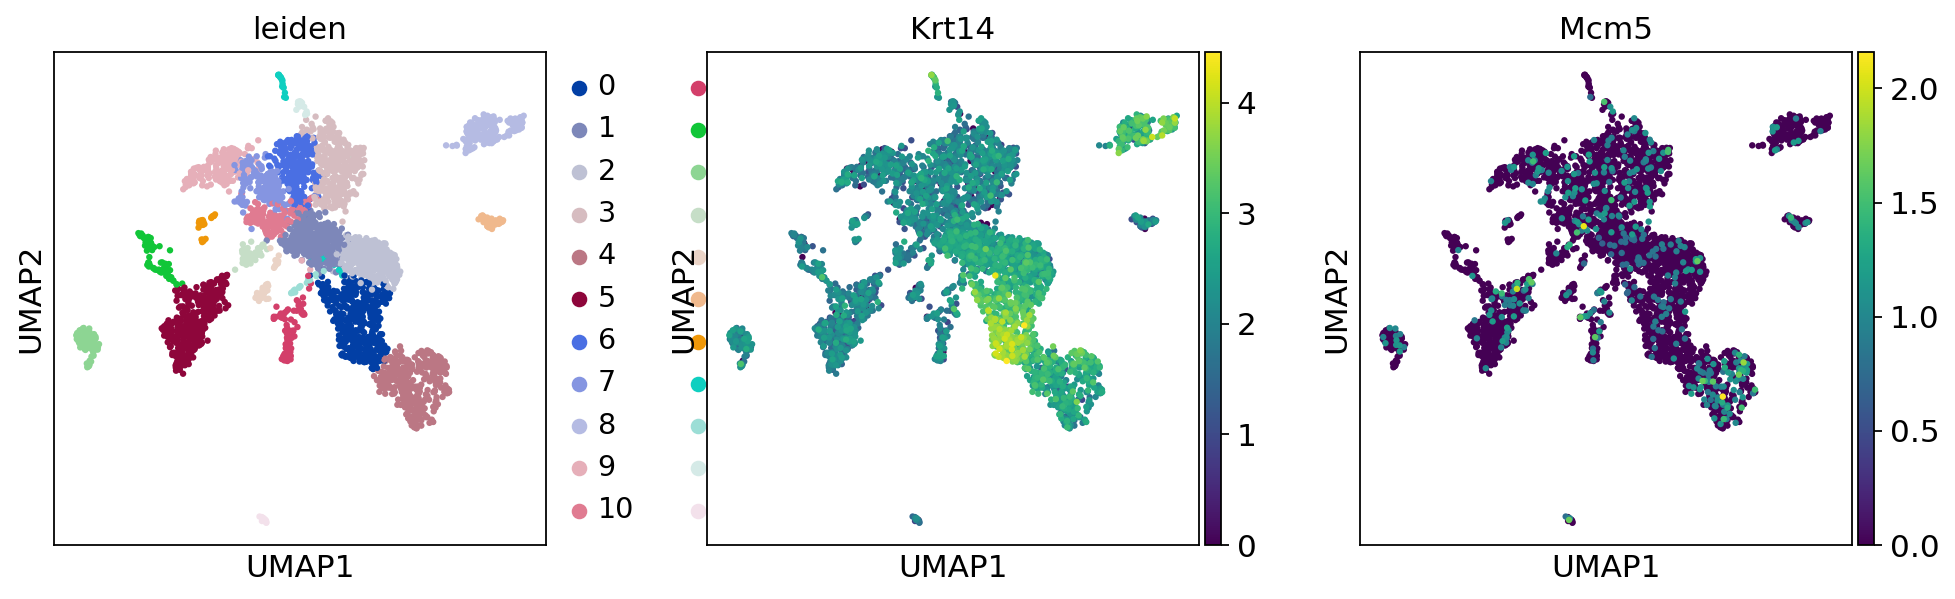

In [38]:
sc.pl.umap(adata, color=["leiden", "Krt14", "Mcm5"])

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:44)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


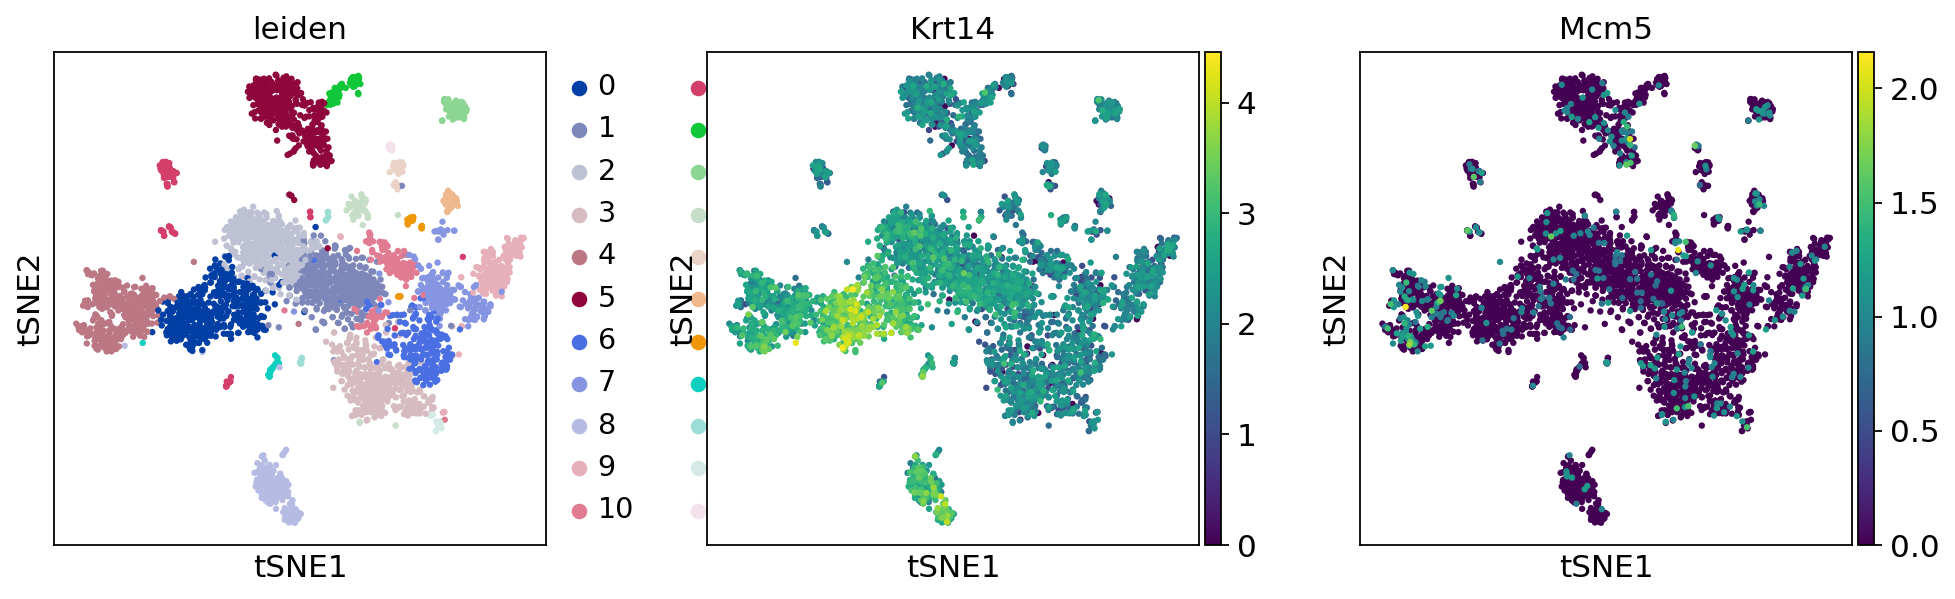

In [39]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=["leiden", "Krt14", "Mcm5"])

In [40]:
adata.write(results_file)

## Finding markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

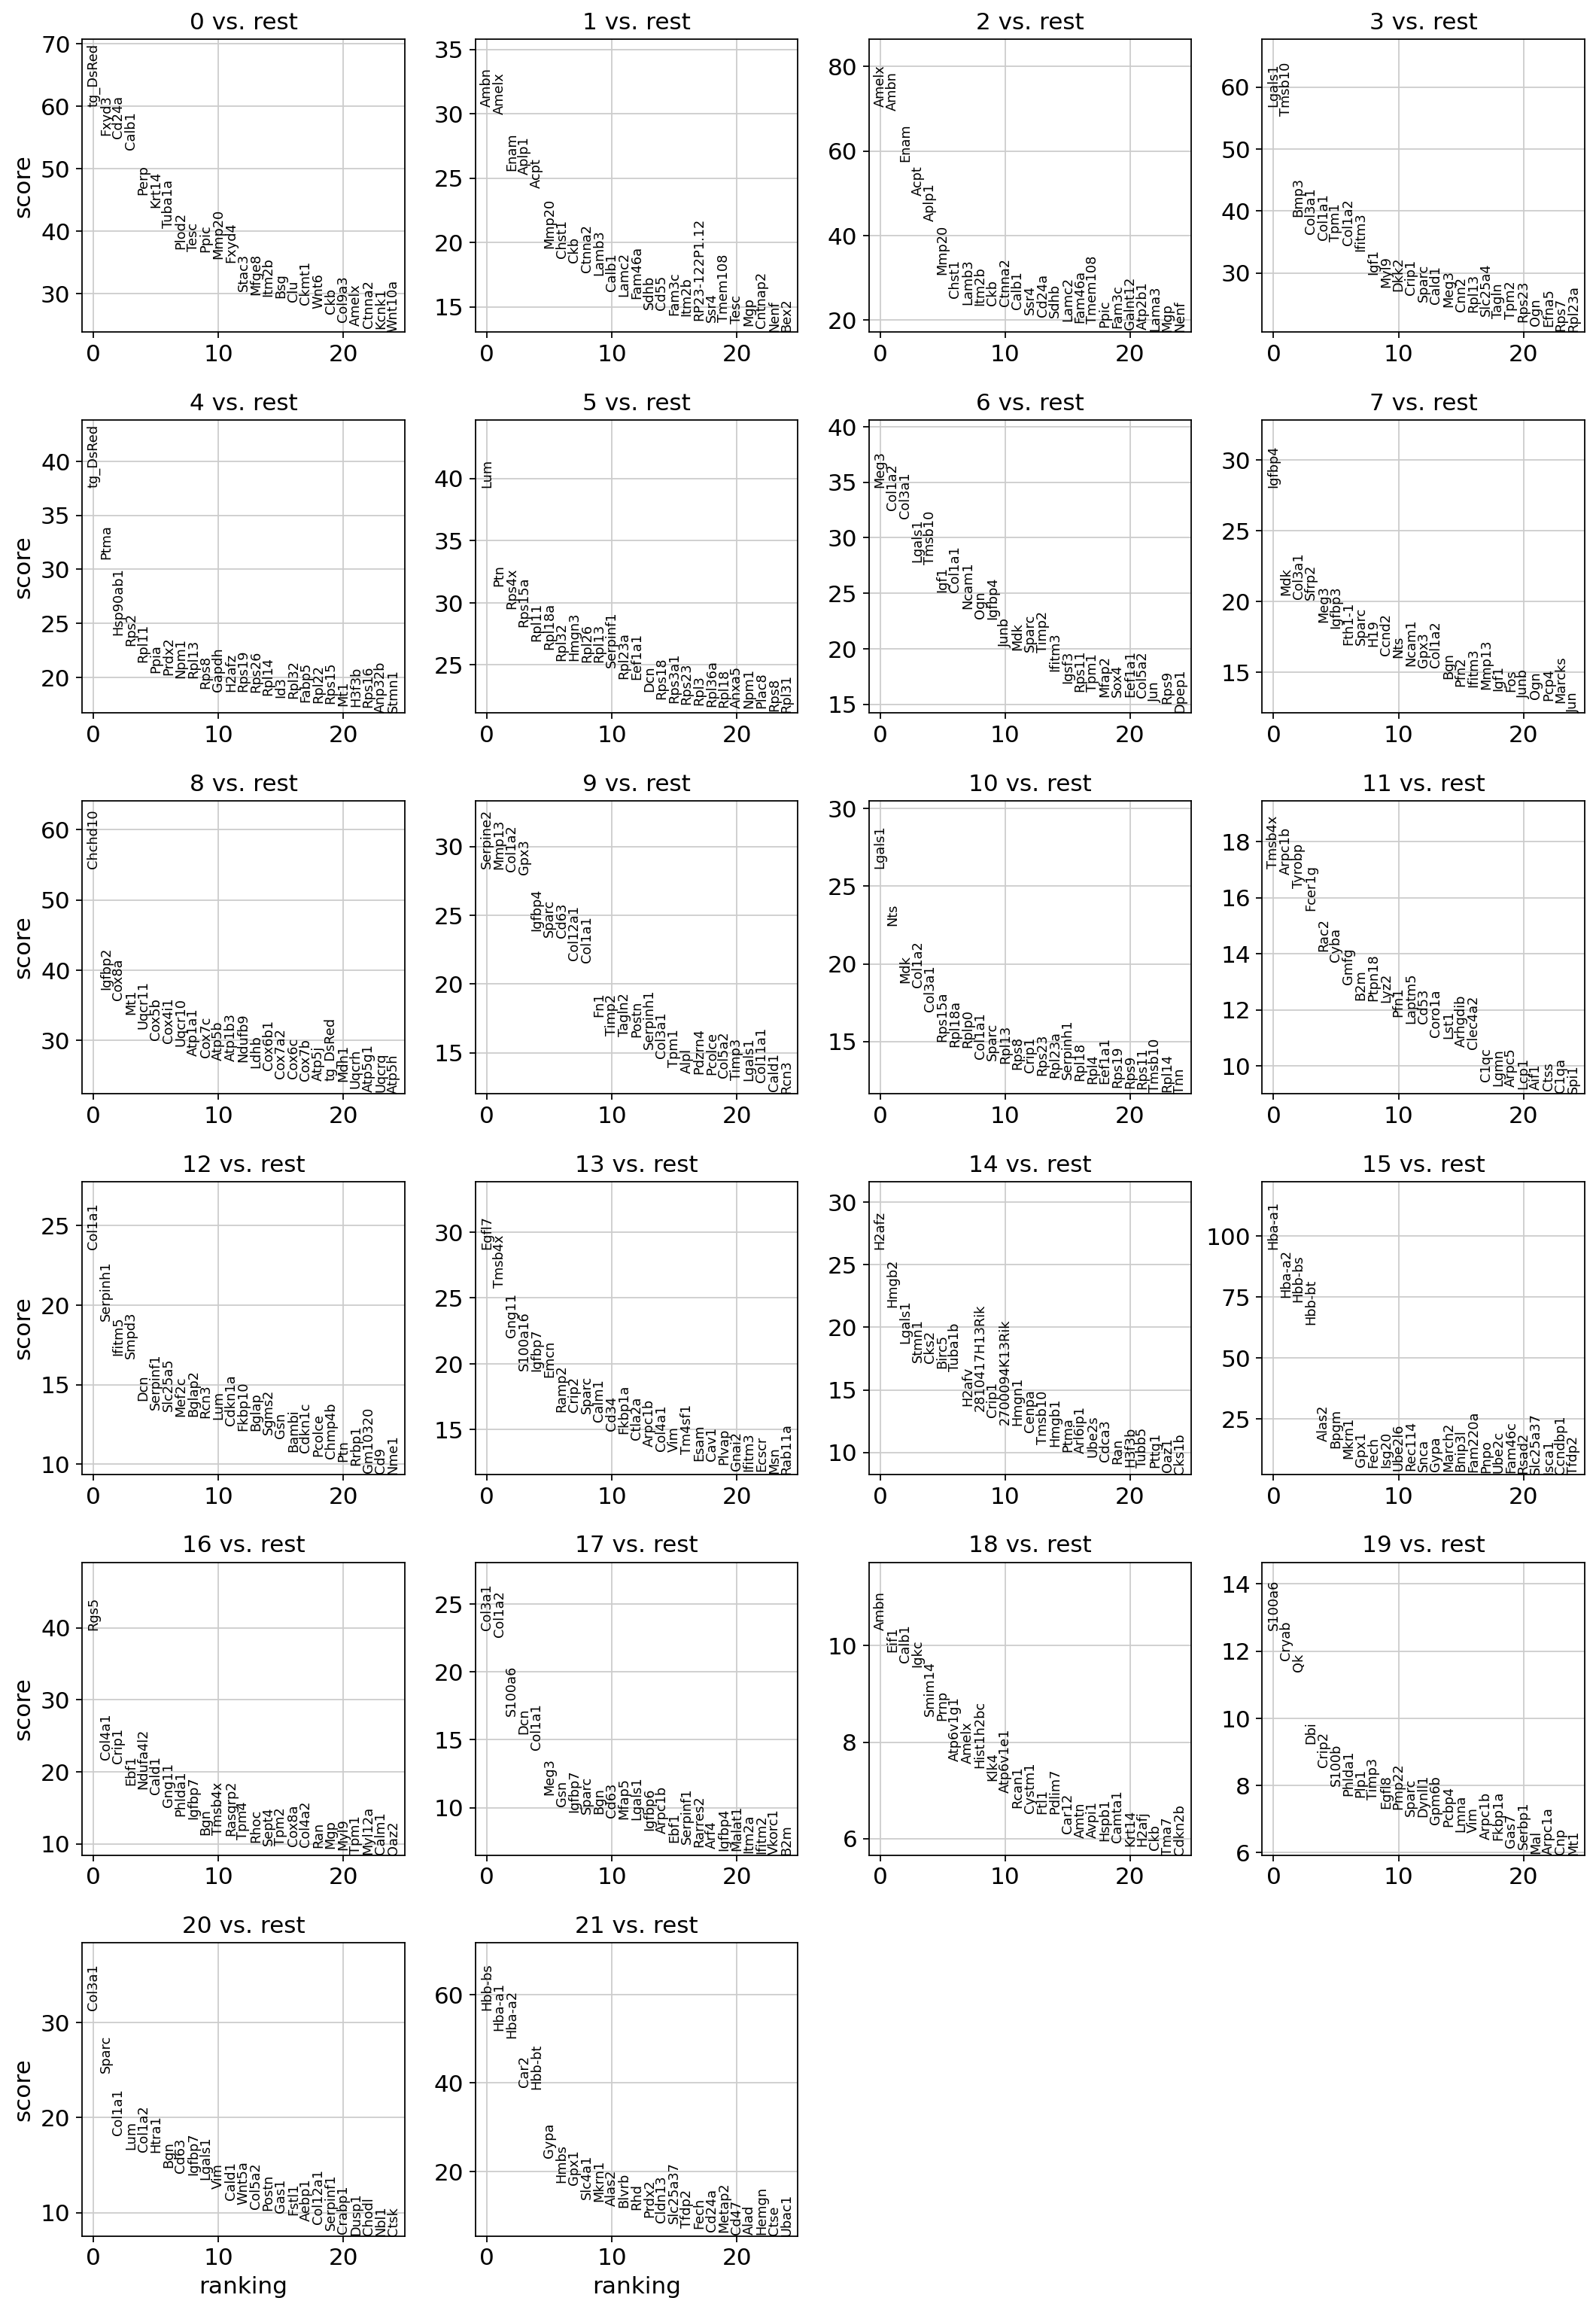

In [41]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Try another test

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

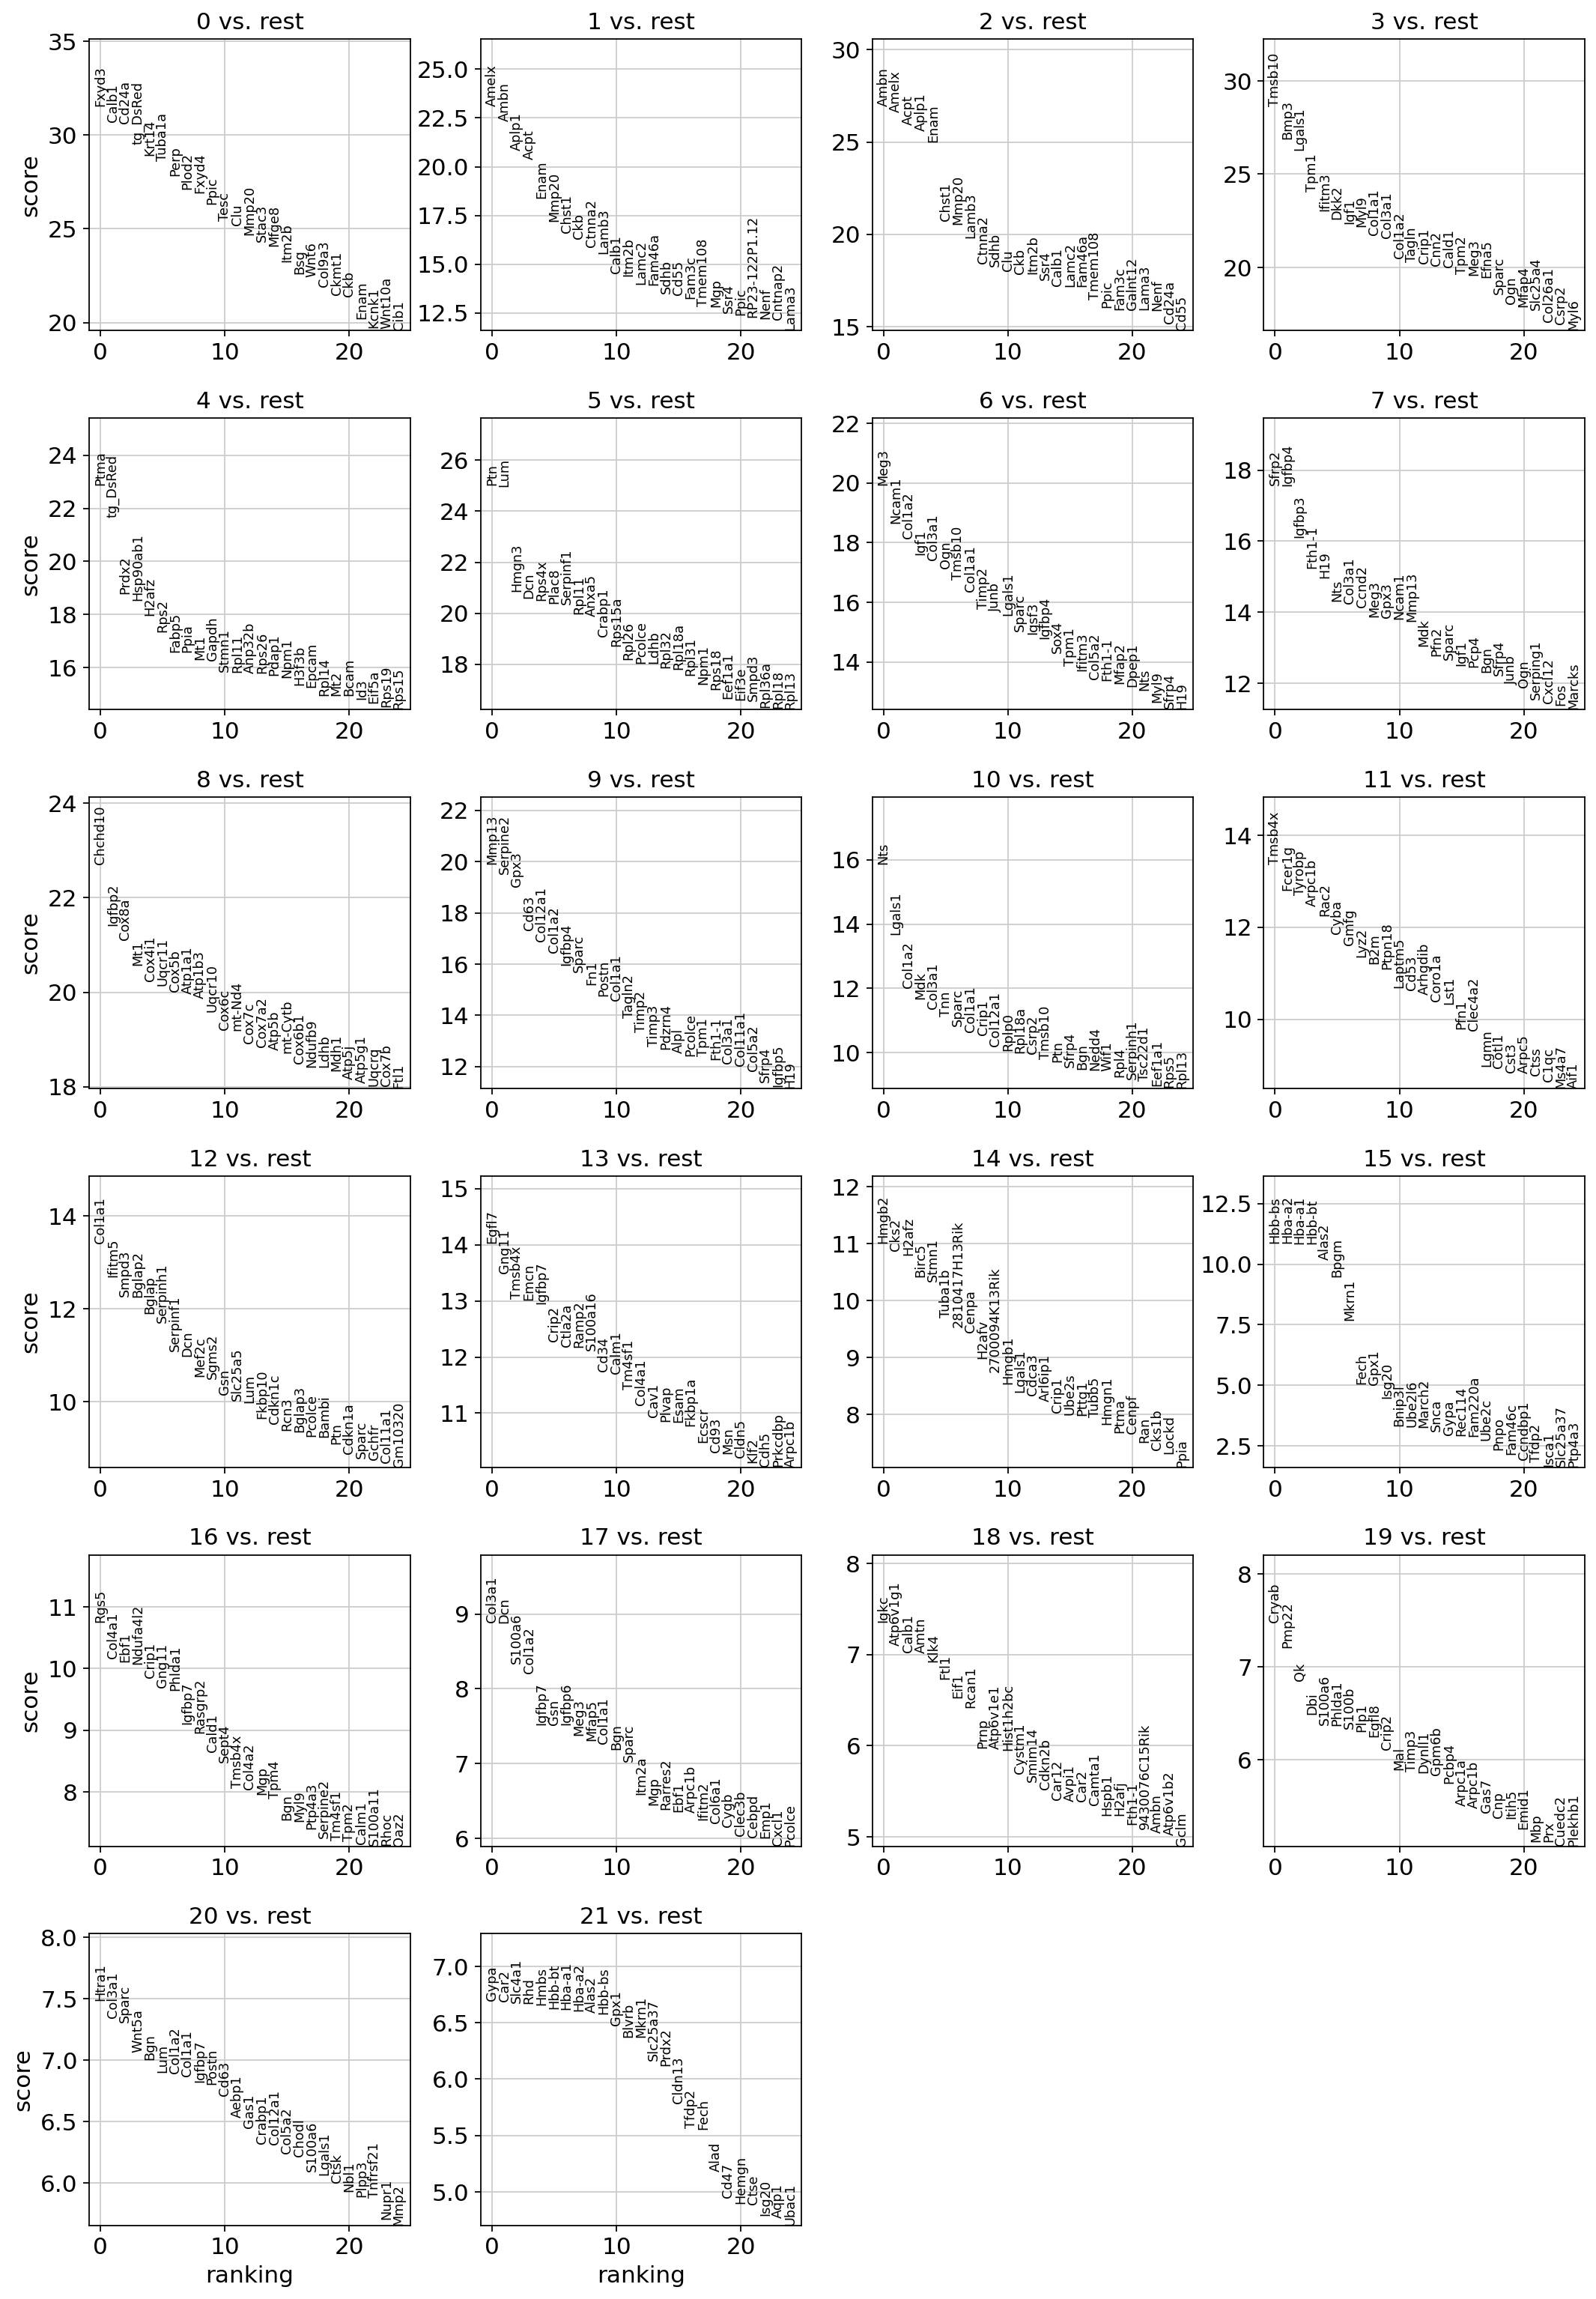

In [42]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [50]:
# Known markers
marker_genes = [
    *["Tbx1", "Sfrp5", "Notch1", "Notch2", "Dmp1"]
]

In [44]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

0      1      2       3         4      5       6       7        8  \
0     Fxyd3  Amelx   Ambn  Tmsb10      Ptma    Ptn    Meg3   Sfrp2  Chchd10   
1     Calb1   Ambn  Amelx    Bmp3  tg_DsRed    Lum   Ncam1  Igfbp4   Igfbp2   
2     Cd24a  Aplp1   Acpt  Lgals1     Prdx2  Hmgn3  Col1a2  Igfbp3    Cox8a   
3  tg_DsRed   Acpt  Aplp1    Tpm1  Hsp90ab1    Dcn    Igf1  Fth1-1      Mt1   
4     Krt14   Enam   Enam  Ifitm3     H2afz  Rps4x  Col3a1     H19   Cox4i1   

          9  ...      12      13     14      15        16      17        18  \
0     Mmp13  ...  Col1a1   Egfl7  Hmgb2  Hbb-bs      Rgs5  Col3a1      Igkc   
1  Serpine2  ...  Ifitm5   Gng11   Cks2  Hba-a2    Col4a1     Dcn  Atp6v1g1   
2      Gpx3  ...   Smpd3  Tmsb4x  H2afz  Hba-a1      Ebf1  S100a6     Calb1   
3      Cd63  ...  Bglap2    Emcn  Birc5  Hbb-bt  Ndufa4l2  Col1a2      Amtn   
4   Col12a1  ...   Bglap  Igfbp7  Stmn1   Alas2     Crip1  Igfbp7      Klk4   

       19      20      21  
0   Cryab   Htra1    Gypa  
1   Pmp22  Col3a1    Car2  
2      Qk   Sparc  Slc4a1  
3     Dbi   Wnt5a     Rhd  
4  S100a6     Bgn    Hmbs  

[5 rows x 22 columns]

In [45]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

0_n            0_p    1_n            1_p    2_n            2_p  \
0     Fxyd3  3.722808e-218  Amelx  5.032408e-118   Ambn  8.685442e-160   
1     Calb1  7.921027e-207   Ambn  1.167805e-110  Amelx  7.700862e-156   
2     Cd24a  4.422813e-206  Aplp1   2.235838e-96   Acpt  4.628799e-148   
3  tg_DsRed  3.656483e-191   Acpt   2.544089e-92  Aplp1  1.229941e-144   
4     Krt14  7.195936e-184   Enam   2.670282e-75   Enam  1.097836e-137   

      3_n            3_p       4_n            4_p  ...    17_n          17_p  \
0  Tmsb10  2.463400e-180      Ptma  9.435504e-116  ...  Col3a1  6.036081e-19   
1    Bmp3  5.424907e-159  tg_DsRed  6.729392e-104  ...     Dcn  6.810025e-19   
2  Lgals1  2.652598e-152     Prdx2   1.152590e-78  ...  S100a6  7.450477e-17   
3    Tpm1  6.442931e-128  Hsp90ab1   1.395571e-76  ...  Col1a2  2.302556e-16   
4  Ifitm3  4.827649e-117     H2afz   3.565691e-72  ...  Igfbp7  5.743759e-14   

       18_n          18_p    19_n          19_p    20_n          20_p    21_n  \
0      Igkc  1.906802e-13   Cryab  7.349744e-14   Htra1  7.436636e-14    Gypa   
1  Atp6v1g1  1.287297e-12   Pmp22  5.927267e-13  Col3a1  2.055815e-13    Car2   
2     Calb1  2.114550e-12      Qk  7.568743e-12   Sparc  2.823996e-13  Slc4a1   
3      Amtn  2.238502e-12     Dbi  8.829302e-11   Wnt5a  1.635524e-12     Rhd   
4      Klk4  4.584466e-12  S100a6  1.848288e-10     Bgn  2.522798e-12    Hmbs   

           21_p  
0  2.188902e-11  
1  2.295339e-11  
2  2.481299e-11  
3  2.558013e-11  
4  2.767097e-11  

[5 rows x 44 columns]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


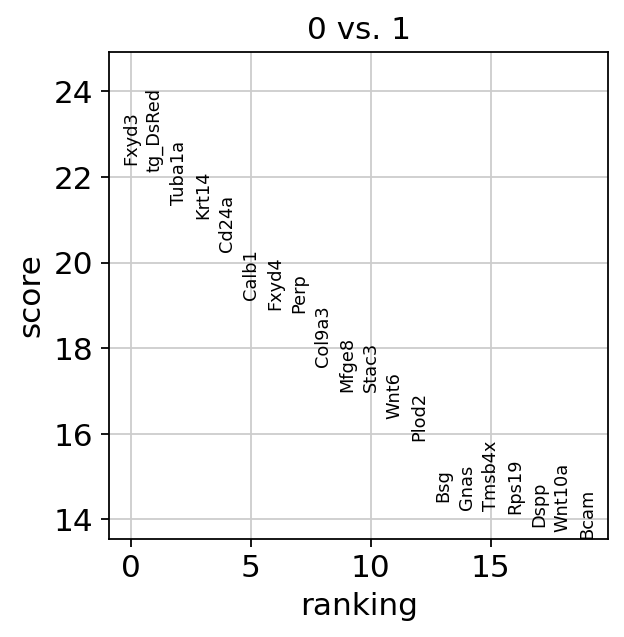

In [46]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.

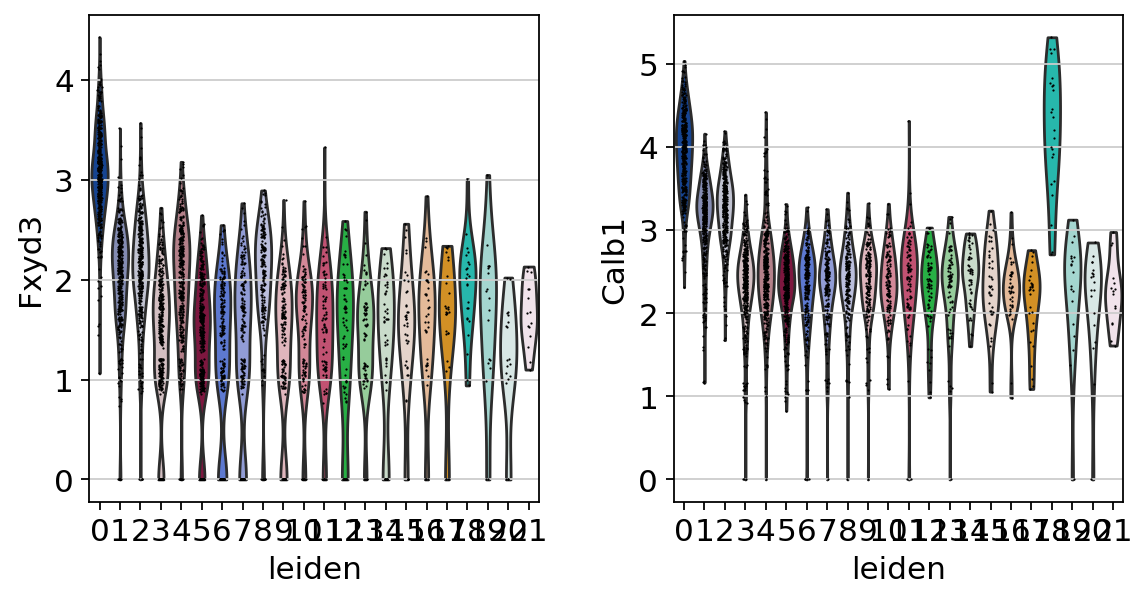

In [48]:
# plot genes across clusters
sc.pl.violin(adata, ["Fxyd3", "Calb1"], groupby="leiden")

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


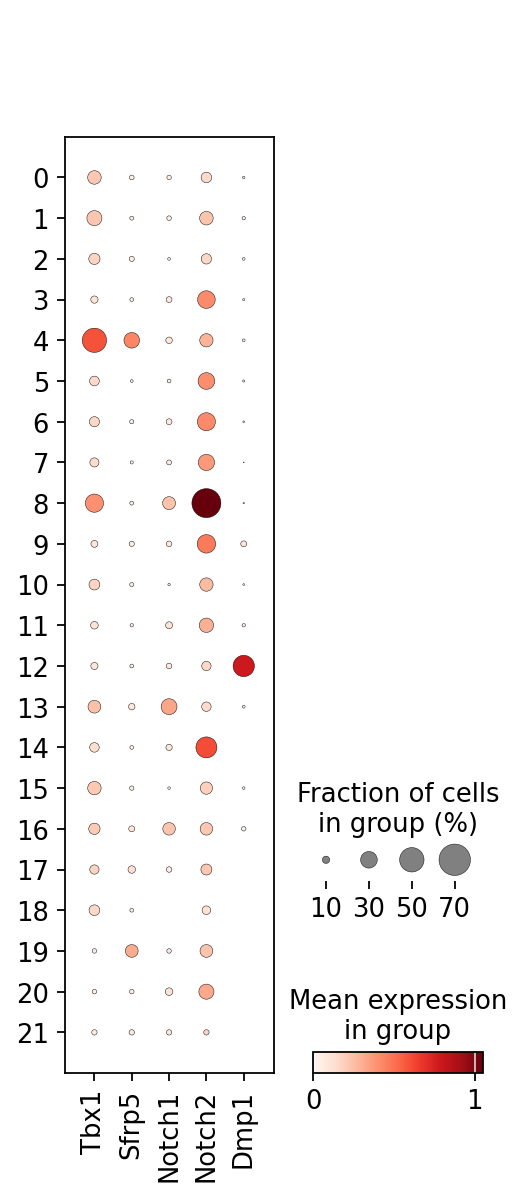

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and

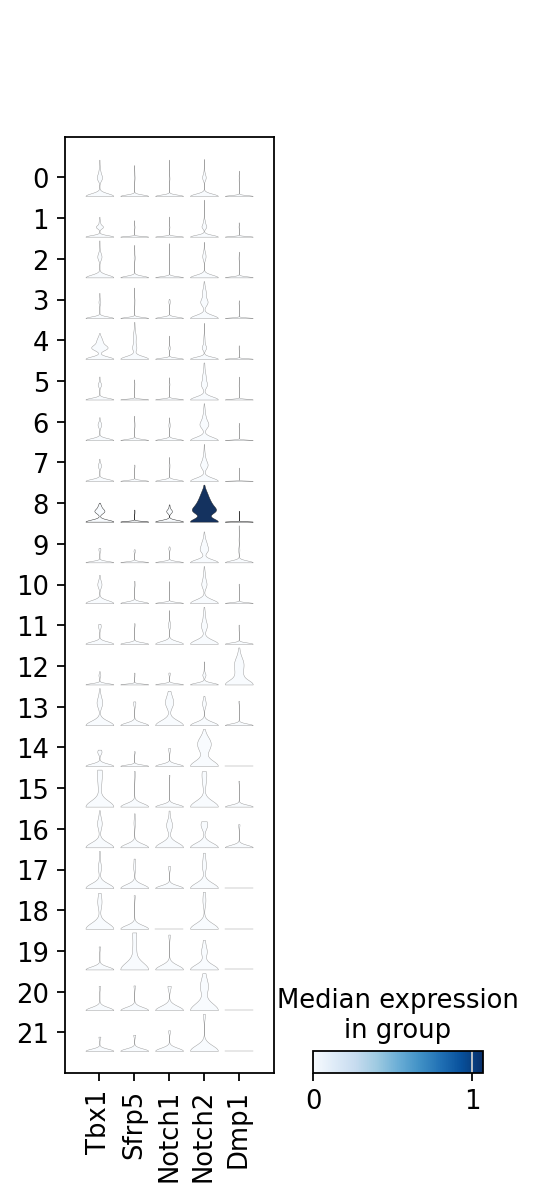

In [51]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden")
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden")

## Clustering with markers

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


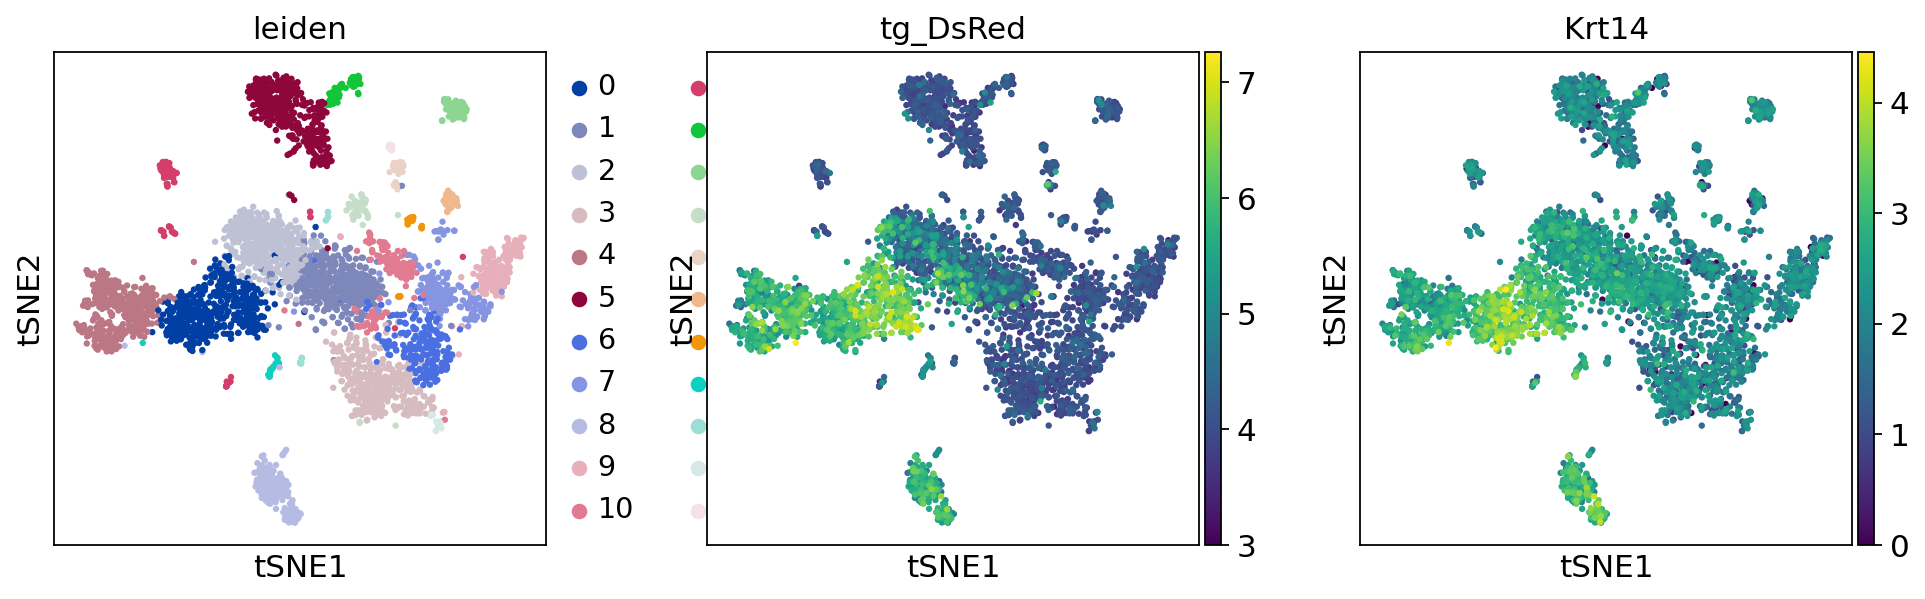

In [56]:
sc.pl.tsne(adata, color=["leiden", "tg_DsRed", "Krt14"])

 Expression of cell-type-specific marker genes projected onto the t-SNE plot from the publication

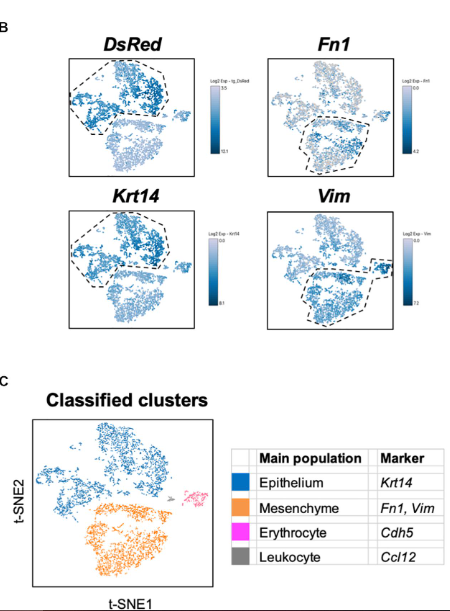

Looks like the results are a little different

## Save data for later

In [52]:
adata

AnnData object with n_obs × n_vars = 3611 × 1545
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'tsne', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [57]:
adata.write(results_file, compression="gzip")